# Chercher les paires pour le présent indicatif dans Lexique3

In [ ]:
import codecs,math,pickle,re,math
import pandas as pd
import numpy as np
import itertools as it
import matplotlib as mplt
import matplotlib.pyplot as plt

In [12]:
pd.__version__

u'0.23.1'

In [2]:
%matplotlib inline

In [3]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("hls")
sns.set_color_codes("muted")
#sns.palplot(sns.color_palette("hls", 8))
#sns.palplot(sns.color_palette("husl", 8))

In [10]:
repHDR="/Users/gilles/ownCloud/Recherche/Boye/HDR/Memoire/figs/"
nomRepertoire="/Volumes/gilles/Transfert/Copies-iMac-GB/Python/phonemisation/"
nomLexiqueOrg=nomRepertoire+"Lexique380-UTF8.txt"
Lexique3=pd.read_csv(nomLexiqueOrg,sep="\t")
nomVerbes3="/Users/gilles/ownCloud/Recherche/Boye/HDR/Data/Samples/MGC-171229-Verbes3.pkl"

In [83]:
presentCases="pi1S pi2S pi3S pi1P pi2P pi3P".split(" ")

In [9]:
Lexique3.columns

Index([u'1_ortho', u'2_phon', u'3_lemme', u'4_cgram', u'5_genre', u'6_nombre',
       u'7_freqlemfilms2', u'8_freqlemlivres', u'9_freqfilms2',
       u'10_freqlivres', u'11_infover', u'12_nbhomogr', u'13_nbhomoph',
       u'14_islem', u'15_nblettres', u'16_nbphons', u'17_cvcv', u'18_p_cvcv',
       u'19_voisorth', u'20_voisphon', u'21_puorth', u'22_puphon', u'23_syll',
       u'24_nbsyll', u'25_cv-cv', u'26_orthrenv', u'27_phonrenv',
       u'28_orthosyll', u'29_cgramortho', u'30_deflem', u'31_defobs',
       u'32_old20', u'33_pld20', u'34_morphoder', u'35_nbmorph'],
      dtype='object')

Avec le changement de version de pandas, les anciens pickle ne sont plus compatibles avec la nouvelle version 0.23.1, pd.read_pickle permet de lire un fichier pkl contenant un DataFrame datant d'une version précédente de pandas mais pas un dictionnaire de DataFrame...

In [26]:
verbes3=pd.read_pickle(nomVerbes3)

In [55]:
verbesPresentLex3=verbes3[(verbes3["freq"]>10000)&(verbes3["vs"]=="pi")]

In [56]:
presentVerbes3=verbesPresentLex3.pivot_table(values='phono', index=['lexeme'], columns=['case'], aggfunc=lambda x: ",".join(x)).reset_index().reindex()
presentVerbes3=presentVerbes3["lexeme pi1S pi2S pi3S pi1P pi2P pi3P".split(" ")]
print u"Nombre de lexèmes",presentVerbes3.count()["lexeme"]
presentCompletVerbes3=presentVerbes3.dropna(thresh=7)
print u"Nombre de lexèmes complets",presentCompletVerbes3.count()["lexeme"]

Nombre de lexèmes 4245
Nombre de lexèmes complets 857


In [69]:
for df in [presentVerbes3,presentCompletVerbes3]:
    selG1=df["lexeme"].str.endswith(u"er")
    selG2=(df["pi1S"].str.endswith(u"i"))&(df["pi3P"].str.endswith(u"is"))
    selG3=(~selG1)&(~selG2)
    print df.count()["lexeme"]
    for sel in [selG1,selG2,selG3]:
        print df[sel].count()["lexeme"]
    print

4245
3684
131
430

857
666
42
149



# Calcul de la HeatMap

In [71]:
def tableauPaires(gParadigme):
    lTable=pd.DataFrame(columns=["ligne","colonne","nbPaires"])
    refCases=gParadigme.columns.tolist()
    for n,paire in enumerate(it.combinations_with_replacement(refCases,2)):
        if n%1000==0:
            print n,paire
        if paire[0] in gParadigme.columns and paire[1] in gParadigme.columns:
            nbPaires=len(gParadigme[[paire[0],paire[1]]].dropna())
        else:
            nbPaires=0
        lTable.loc[2*n]=[paire[0],paire[1],nbPaires]
        lTable.loc[2*n+1]=[paire[1],paire[0],nbPaires]
    print "table finie"
    lTable=lTable.drop_duplicates()
    lTable["nbPaires"]=lTable["nbPaires"].astype(int)
    lTableau=lTable.pivot_table(index="ligne",columns=["colonne"])
    #
    # Ici, il faut renvoyer le tableau["nbPaires"] pour éviter l'enchassemement des colonnes
    #
    return lTableau["nbPaires"]

In [72]:
def getTableauPaire(gDF,thresh=3):
    threshCol=thresh
    colThresh=[k for k,v in gDF.count().to_dict().iteritems() if v>=threshCol]
    nbCols=len(colThresh)
    f=math.factorial
    print f(nbCols) //2 // f(nbCols-2),"paires"

    tableauDerif=tableauPaires(gDF[sorted(colThresh)])
    return tableauDerif

In [77]:
bounds = np.array([0, 30, 300, 2000, 5000])
norm = mplt.colors.BoundaryNorm(boundaries=bounds, ncolors=100)

In [91]:
df=getTableauPaire(presentVerbes3[presentCases])
df=df[presentCases]
df=df.reindex(presentCases[::-1])
df

15 paires
0 (u'pi1P', u'pi1P')
table finie


colonne,pi1S,pi2S,pi3S,pi1P,pi2P,pi3P
ligne,,,,,,
pi3P,2420,1614,2905,1211,1734,3043
pi2P,1797,1344,1886,1071,1926,1734
pi1P,1215,941,1266,1289,1071,1211
pi3S,2900,1805,3988,1266,1886,2905
pi2S,1677,1838,1805,941,1344,1614
pi1S,2968,1677,2900,1215,1797,2420


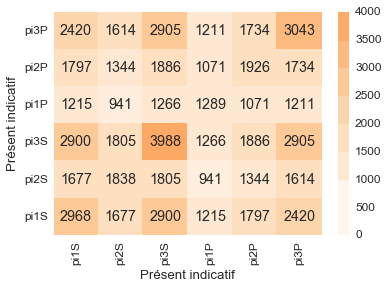

In [100]:
bounds = np.array([0, 500, 1000, 1500, 2000,2500,3000,3500,4000])
norm = mplt.colors.BoundaryNorm(boundaries=bounds, ncolors=100)
fig, ax = plt.subplots()
sns.heatmap(df,cmap="Oranges",norm=norm,annot=True,fmt="g",cbar_kws={"ticks":bounds},ax=ax,cbar=True)
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.xlabel(u'Présent indicatif') 
plt.ylabel(u'Présent indicatif') 


21 paires
0 ('lexeme', 'lexeme')
table finie


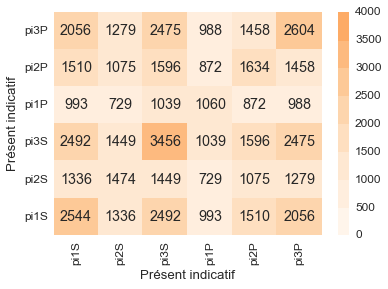

In [123]:
df=presentVerbes3
selG1=df["lexeme"].str.endswith(u"er")
selG2=(df["pi1S"].str.endswith(u"i"))&(df["pi3P"].str.endswith(u"is"))
selG3=(~selG1)&(~selG2)

df=getTableauPaire(df[selG1])
df=df[presentCases]
df=df.reindex(presentCases[::-1])

bounds = np.array([0, 500, 1000, 1500, 2000,2500,3000,3500,4000])
norm = mplt.colors.BoundaryNorm(boundaries=bounds, ncolors=100)
fig, ax = plt.subplots()
sns.heatmap(df,cmap="Oranges",
            norm=norm,annot=True,fmt="g",
            cbar_kws={"ticks":bounds},ax=ax,
            vmin=0,vmax=4000,
            cbar=True)
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.xlabel(u'Présent indicatif') 
plt.ylabel(u'Présent indicatif') 
